### Simulation of a Helicene molecule in the Hubbard-I-approximation

In this Notebook, the transport-properties (current, spin-polarization in the transmission (SPT), magnetoresistance (MR), etc.) of a Helicene molecule containing SOI and Coulomb-interactions are evaluated in the Hubbard-I approximation, i.e. treating the correlations in the on-site electron-electron interactions up to the 2nd order.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Defining functions for indexing of the helicene's sites.

In this Notebook, the sites of the helicene molecule are labeled by two indices $(i_{hex}, i_{site})$. Here, i_hex numbers the hexagon to which the site belongs, such that $i_{hex} = 0$ corresponds to the first hexagon from the left lead, until $i_{hex} = N_{hex} - 1$, where $N_{hex}$ is the total number of hexagons. The helicene molecule can be decomposed into $N_{hex}$ groups of 4 sites, which correspond to the label $i_{site}$.  in which the label $i_{site}=0$ corresponds to the left-most site on the inner helix, while $i_{site} = 1$ corresponds to the left-most site of the middle helix. The sites $i_{site} = 2,3$ correspond to the left and right sites on the outer helix, respectively. The sites $i_{site} = 0,1$ on the subsequent hexagon make up the remaining corners of the incomplete hexagon.

In [2]:
def index_1D_per(Struct_dims):
    """
    Input:
        Struct_dims = [N1, N_struct], where:
            N1 :  number of times the structure is repeated
            N_struct :  number of elements within a single repeated unit
    """
    N1, N_struct = int(Struct_dims[0]), int(Struct_dims[1])
    N_tot = N1*N_struct
    ind_arr = np.arange(0,N_tot)
    ind_arr_res = np.reshape(ind_arr, newshape = [N1, N_struct])
    return ind_arr.astype(int), ind_arr_res.astype(int)

def inv_index_1D_per(Struct_dims):
    N1, N_struct = int(Struct_dims[0]), int(Struct_dims[1])
    ind_dim0 = np.expand_dims(np.arange(0, N1), axis = 1)
    ind_dim = np.repeat(ind_dim0, repeats = N_struct, axis = 1)
    ind_dim = np.reshape(ind_dim, newshape = [N1*N_struct])
    
    ind_struct0 = np.arange(0,N_struct)
    ind_struct = np.array(list(ind_struct0)*N1)
    
    ind_store = np.zeros([N1*N_struct, 2])
    ind_store[:,0] = ind_dim; ind_store[:,1] = ind_struct
    return ind_store.astype(int)


Import the function for the higher-order integration of functions
### Note: ### 
The argument of sys.path.append() should be changed from 'C:\\Users\janbr\Downloads\MEP files\Code') to the location where this file is stored on your device.

Also, change the file's name from "N_order_integrator_only_functions" if the file's name has changed

The code can also be run without this file, which will however reduce the quality/resolution of the obtained output. This can be achieved by replacing all integrate_n_flipaxes() in the code with delta_E \* np.sum(-1j*G_less_store, axis = 0), where delta_E = np.abs(e_arr[1] - e_arr[0]) is the resolution of the respective energy-array.

In [3]:
import sys
sys.path.append('C:\\Users\janbr\Downloads\MEP files\Code')    

from N_order_integrator_only_functions import integrate_n_flipaxes

In [4]:
    
N_hex = 3
Struct_mol_dims = [N_hex,4]
H_shape = Struct_mol_dims + [2] + Struct_mol_dims + [2]

I_mol = index_1D_per(Struct_mol_dims)[1]; Iinv_mol = inv_index_1D_per(Struct_mol_dims)
Iinv_mol[:,1]

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])

Defining a function for generating the positions of helicene molecule's sites 

In [5]:
def get_pos(pitch_hel, Phi0 = np.pi/3, dPhi0 = 19.1*np.pi/180):
    R_arr = np.zeros(Struct_mol_dims)
    R_arr[:,0] = 1.4
    R_arr[:,1] = 2
    R_arr[:,2] = np.sqrt(7)
    R_arr[:,3] = np.sqrt(7)


    Phi_vals = Phi0*np.arange(0,Struct_mol_dims[0])
    Phi_arr = np.zeros(Struct_mol_dims)
    Phi_arr[:,0] = Phi_vals
    Phi_arr[:,1] = Phi_vals
    Phi_arr[:,2] = Phi_vals + dPhi0
    Phi_arr[:,3] = Phi_vals + Phi0 - dPhi0

    Pos_arr = np.zeros([3] + Struct_mol_dims)
    Pos_arr[0] = R_arr*np.cos(Phi_arr)
    Pos_arr[1] = R_arr*np.sin(Phi_arr)
    Pos_arr[2] = pitch_hel/(2*np.pi)*(Phi_arr)
    
    return Pos_arr



#### On-site energies, tunnel and SOI couplings

The links between sites are assumed to be periodic with the hexagons. This periodic nature is incorporated into the notation (i,j,k) used for the tunnel and SOI coupling links, where (i,j,k) corresponds to all links between site j on the (i+N)-th hexagon and the site k on the N-th hexagon (for any N s.t. N, i+N within the molecule)


In [6]:
E_site = 0

#Links between sites are assumed to be periodic with the hexagons
#This periodic nature is incorporated into the notation (i,j,k) used for the tunnel and SOI coupling links
#The notation (i,j,k) corresponds to all links between site j on the (i+N)-th hexagon and the site k on the N-th hexagon (for any N s.t. N, i+N within the molecule)

Tunnel_ind = ((0,1,0), (0,2,1), (0,3,2), (1,1,3), (1,0,0))
Tunnel_vals = 1*np.array([2,3,2,3,2.5])

SOI_ind = ((0,1,0), (0,2,1), (0,3,2), (1,1,3), (1,0,0))
SOI_lambda = 1*np.array([0.5]*5, dtype = 'complex128')
E_const = np.array([1,0,1], dtype = 'complex128')

In [7]:
def generate_H(Pos_arr, E_const):
    H_shape = Struct_mol_dims + [2] + Struct_mol_dims + [2]
    sigma0 = np.eye(2,2,k=0)

    H0_test = np.zeros(H_shape, dtype = 'complex128')
    
    E_onsite_arr = np.zeros(H_shape, dtype = 'complex128')
    Tau_arr = np.zeros(H_shape, dtype = 'complex128')
    SOI_arr = np.zeros(H_shape, dtype = 'complex128')

    Pauli_vec = np.zeros([2,2,3], dtype = 'complex128')

    Pauli_vec[:,:,0] = np.array([[0,1],[1,0]])
    Pauli_vec[:,:,1] = np.array([[0,-1j],[1j,0]])
    Pauli_vec[:,:,2] = np.array([[1,0],[0,-1]])

    #print(H0_test.shape)

    diag0 = np.arange(0,H0_test.shape[0])

    for i in range(0,H0_test.shape[1]):
        E_onsite_arr[diag0,i,:,diag0,i,:] = E_site*sigma0

    for i in range(0, len(Tunnel_ind)):
        Hex_ind = Tunnel_ind[i][0]
        Site_ind1, Site_ind2 = Tunnel_ind[i][1], Tunnel_ind[i][2]
        if Hex_ind == 0:
            diag_i1 = diag0; diag_i2 = diag0
        if Hex_ind != 0:
            diag_i1 = diag0[Hex_ind:]; diag_i2 = diag0[:(-Hex_ind)]
        Tau_arr[diag_i1, Site_ind1, :, diag_i2, Site_ind2] = Tunnel_vals[i]*sigma0
        Tau_arr[diag_i2, Site_ind2, :, diag_i1, Site_ind1] = np.conj(np.transpose(Tunnel_vals[i]*sigma0))



    HSOI_store = []
    for i in range(0, len(SOI_ind)):
        Hex_ind = SOI_ind[i][0]
        Site_ind1, Site_ind2 = SOI_ind[i][1], SOI_ind[i][2]
    #    print(Site_ind1);print(Site_ind2)
        if Hex_ind == 0:
            dPosi = (Pos_arr[:,:,Site_ind1] - Pos_arr[:,:,Site_ind2])
            dPosi_norm = np.sqrt(np.sum(dPosi**2, axis = 0))
            dPosi = np.copy(dPosi/dPosi_norm)
        if Hex_ind != 0:
            dPosi = Pos_arr[:,Hex_ind:,Site_ind1] - Pos_arr[:,:(-Hex_ind),Site_ind2]
            dPosi_norm = np.sqrt(np.sum(dPosi**2, axis = 0))
            dPosi = np.copy(dPosi/dPosi_norm)
        dPosi = np.cross(np.swapaxes(dPosi, 0, -1), E_const)  
        dPosi_ext = np.repeat(np.expand_dims(dPosi, axis = -2), 2, axis = -2)
        dPosi_ext = np.repeat(np.expand_dims(dPosi_ext, axis = -2), 2, axis = -2)

        HSOI_i = -1j*SOI_lambda[i]*np.sum(Pauli_vec*dPosi_ext, axis = 3)
        HSOI_store.append(HSOI_i)    


    for i in range(0, len(SOI_ind)):
        Hex_ind = SOI_ind[i][0]
        Site_ind1, Site_ind2 = SOI_ind[i][1], SOI_ind[i][2]
       # print(Site_ind1);print(Site_ind2)
        if Hex_ind == 0:
            diag_i1 = diag0; diag_i2 = diag0
        if Hex_ind != 0:
            diag_i1 = diag0[Hex_ind:]; diag_i2 = diag0[:(-Hex_ind)]
      #      print(diag_i1)
        SOI_arr[diag_i1,Site_ind1,:,diag_i2,Site_ind2,:] = HSOI_store[i]
        SOI_arr[diag_i2,Site_ind2,:,diag_i1,Site_ind1,:] = np.conj(np.swapaxes(HSOI_store[i],-1,-2))
    
    H_tot = E_onsite_arr + Tau_arr + SOI_arr
    return H_tot, E_onsite_arr, Tau_arr, SOI_arr


    

#### On-site Coulomb interactions
The strengths of the sites' Coulomb interactions are assumed to be periodic w.r.t. the hexagons, i.e. $U_{i_{hex},i_{site}} = U_{i_{site}}$. The values of the Coulomb interactions are defined in the array U_vals for $i_{site} = 0,1,2,3$

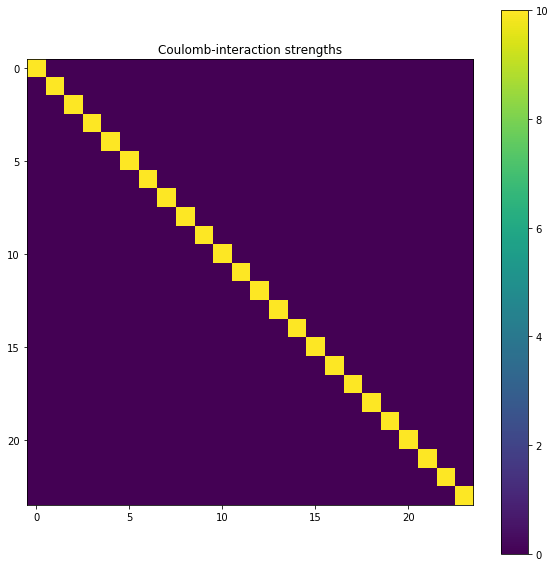

In [8]:
U_onsite_arr = np.zeros(H_shape, dtype = 'complex128')
U_vals = np.array([10.0]*4)
Sigma_0 = np.array([[1,0],[0,1]], dtype = 'complex128')

for i in range(0,len(U_vals)):
    U_vals_i = U_vals[i]
    U_onsite_arr[Iinv_mol[:,0],i,:,Iinv_mol[:,0],i,:] = U_vals_i*Sigma_0
    
plt.figure(figsize = (10,10))
U_onsite_arr_res = np.reshape(U_onsite_arr,[2*H_shape[0]*H_shape[1]]*2)
plt.title('Coulomb-interaction strengths');plt.imshow(np.real(U_onsite_arr_res));plt.colorbar()

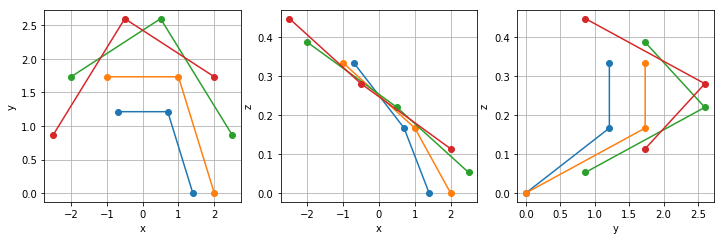

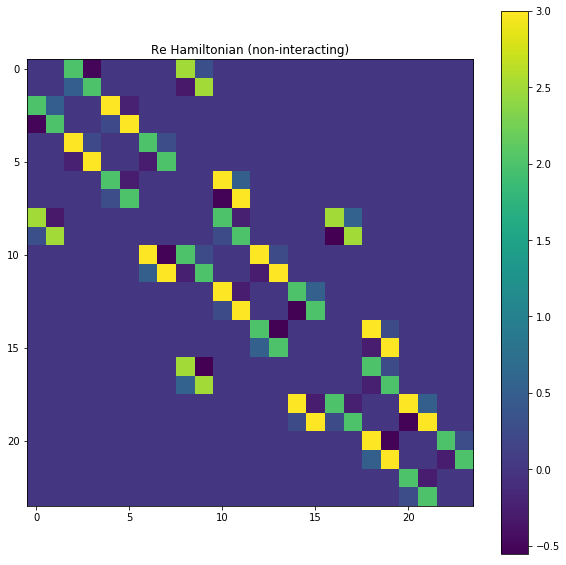

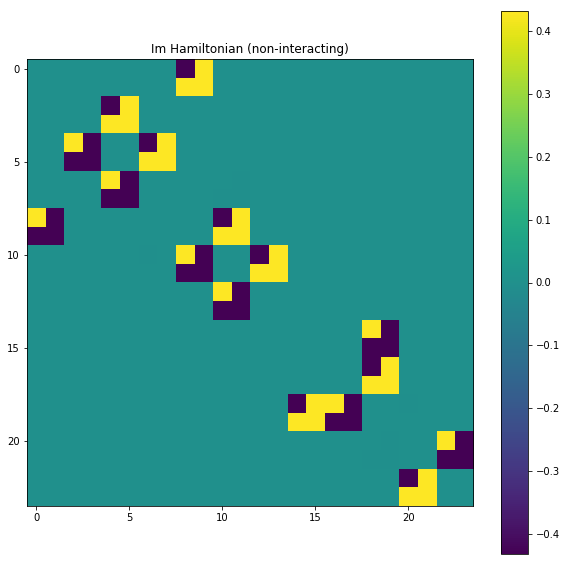

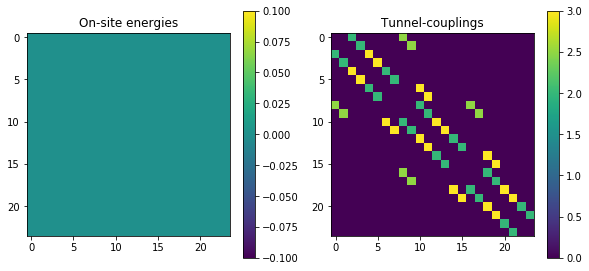

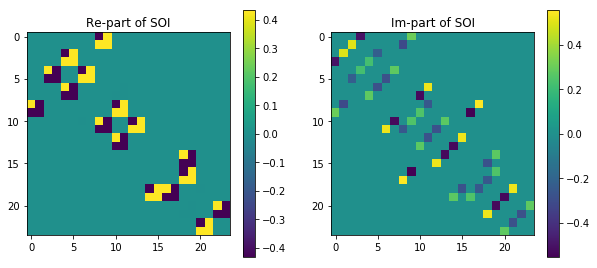

In [9]:
Pos_arr = get_pos(1)

H0, E_onsite_arr, Tau_arr, SOI_arr = generate_H(Pos_arr, np.array([1,0,1], dtype = 'complex128'))

Hres = np.reshape(H0, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
E_onsite_arr_res = np.reshape(E_onsite_arr, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
Tau_arr_res = np.reshape(Tau_arr, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])
SOI_arr_res = np.reshape(SOI_arr, [2*H0.shape[1]*N_hex,2*H0.shape[4]*N_hex])

Id_res = np.eye(2*H_shape[0]*H_shape[1], 2*H_shape[0]*H_shape[1], dtype = 'complex128')

plt.figure(figsize = (12,12))
plt.subplot(331);
for i in range(0,Struct_mol_dims[1]):
    plt.plot(Pos_arr[0,:,i], Pos_arr[1,:,i],'-o')
plt.xlabel('x');plt.ylabel('y');plt.grid()
plt.subplot(332);
for i in range(0,Struct_mol_dims[1]):
    plt.plot(Pos_arr[0,:,i], Pos_arr[2,:,i],'-o')
plt.xlabel('x');plt.ylabel('z');plt.grid()
plt.subplot(333);
for i in range(0,Struct_mol_dims[1]):
    plt.plot(Pos_arr[1,:,i], Pos_arr[2,:,i],'-o')
plt.xlabel('y');plt.ylabel('z');plt.grid();plt.show()

plt.figure(figsize = (10,10))
plt.title('Re Hamiltonian (non-interacting)');plt.imshow(np.real(np.reshape(H0, [N_hex*4*2, N_hex*4*2])));plt.colorbar();plt.show()

plt.figure(figsize = (10,10))
plt.title('Im Hamiltonian (non-interacting)');plt.imshow(np.imag(np.reshape(H0, [N_hex*4*2, N_hex*4*2])));plt.colorbar();plt.show()

plt.figure(figsize = (10,10))
plt.subplot(221);plt.title('On-site energies');plt.imshow(np.real(E_onsite_arr_res));plt.colorbar();
plt.subplot(222);plt.title('Tunnel-couplings');plt.imshow(np.real(Tau_arr_res));plt.colorbar();plt.show()
plt.figure(figsize = (10,10))
plt.subplot(221);plt.title('Re-part of SOI');plt.imshow(np.imag(SOI_arr_res));plt.colorbar();
plt.subplot(222);plt.title('Im-part of SOI');plt.imshow(np.real(SOI_arr_res));plt.colorbar();plt.show()

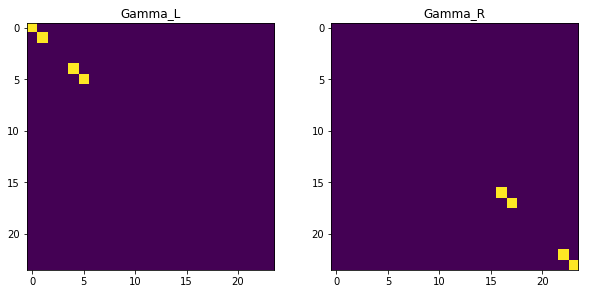

In [10]:
lead_conns_L = [(0,0),(0,2)]
lead_conns_R = [(-1,-1),(-1,0)]

H_shape = Struct_mol_dims + [2] + Struct_mol_dims + [2]

Gamma_L = np.zeros(H_shape, dtype = 'complex128')
Gamma_R = np.zeros(H_shape, dtype = 'complex128')

Spin_proj_down = np.zeros(H_shape, dtype = 'complex128')
Spin_proj_up = np.zeros(H_shape, dtype = 'complex128')

Spin_proj_down[Iinv_mol[:,0], Iinv_mol[:,1], 0, Iinv_mol[:,0], Iinv_mol[:,1], 0] = 1
Spin_proj_up[Iinv_mol[:,0], Iinv_mol[:,1], 1, Iinv_mol[:,0], Iinv_mol[:,1], 1] = 1

Spin_res_down = np.reshape(Spin_proj_down, [Spin_proj_down.shape[0]*Spin_proj_down.shape[1]*2, Spin_proj_down.shape[3]*Spin_proj_down.shape[4]*2])
Spin_res_up = np.reshape(Spin_proj_up, [Spin_proj_up.shape[0]*Spin_proj_up.shape[1]*2, Spin_proj_up.shape[3]*Spin_proj_up.shape[4]*2])

for i in range(0,len(lead_conns_L)):
    conn_i = lead_conns_L[i]
    conn_tot_down = (conn_i + (0,) + conn_i + (0,))
    conn_tot_up = (conn_i + (1,) + conn_i + (1,))
    Gamma_L[conn_tot_down] = 0.5
    Gamma_L[conn_tot_up] = 0.5

for i in range(0,len(lead_conns_R)):
    conn_i = lead_conns_R[i]
    conn_tot_down = (conn_i + (0,) + conn_i + (0,))
    conn_tot_up = (conn_i + (1,) + conn_i + (1,))
    Gamma_R[conn_tot_down] = 0.5
    Gamma_R[conn_tot_up] = 0.5
    

Gamma_L_res = np.reshape(Gamma_L, [Gamma_L.shape[0]*Gamma_L.shape[1]*2,Gamma_L.shape[3]*Gamma_L.shape[4]*2])
Gamma_R_res = np.reshape(Gamma_R, [Gamma_R.shape[0]*Gamma_R.shape[1]*2,Gamma_R.shape[3]*Gamma_R.shape[4]*2])

plt.figure(figsize = (10,10))
plt.subplot(221);plt.title('Gamma_L');plt.imshow(np.real(Gamma_L_res));
plt.subplot(222);plt.title('Gamma_R');plt.imshow(np.real(Gamma_R_res));plt.show()

Sigma_tot = -1j/2*(Gamma_L + Gamma_R)
Sigma_tot_res = np.reshape(Sigma_tot, [Sigma_tot.shape[0]*Sigma_tot.shape[1]*2,Sigma_tot.shape[3]*Sigma_tot.shape[4]*2])



#### Plotting the tunnel and spin-orbit couplings
Plots for visualizing the molecule with the tunnel-couplings, SOI and on-site Coulomb interactions. The intensity of the color (RGB) is proportional to the coupling strength ($|\tau|/|\tau_{max}|$, $|\lambda|/\lambda_{max}$ and $|U|/|U_{max}|$), while couplings with the left and right leads are denoted with 'x' and '+' respectively. Red or blue leads correspond to up- and down-magnetized leads, respectively.

Tunnel-couplings = ((0, 1, 0), (0, 2, 1), (0, 3, 2), (1, 1, 3), (1, 0, 0))
Tunnel-vals. = [2.  3.  2.  3.  2.5]


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Programs\Anaconda3\lib\site-packages\matplotlib\colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
C:\Programs\Anaconda3\lib\site-packages\matplotlib\colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


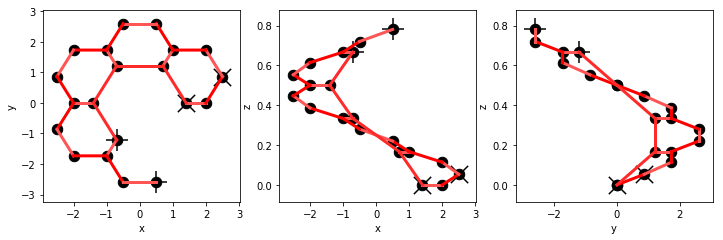

SOI-couplings = ((0, 1, 0), (0, 2, 1), (0, 3, 2), (1, 1, 3), (1, 0, 0))
SOI-lambda = [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


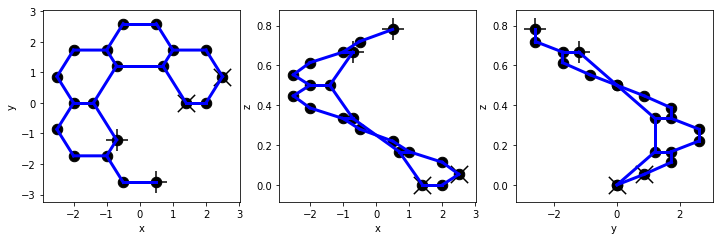

U-sites = (0, 1, 2, 3)
Onsite U-values = [0. 0. 0. 0.]


In [98]:
diag0 = np.arange(0,H_shape[0])

Pos_tun1_list, Pos_tun2_list = [],[]
Pos_SOI1_list, Pos_SOI2_list = [],[]

Tunnel_max = np.max(np.abs(Tunnel_vals))
SOI_max = np.max(np.abs(SOI_lambda))
U_max = np.max(np.abs(U_vals))

for i in range(0,len(Tunnel_ind)):
    Hex_num = Tunnel_ind[i][0]
    Site_num1, Site_num2 = Tunnel_ind[i][1:]
    if Hex_num == 0: diag_i1 = diag0; diag_i2 = diag0
    if Hex_num != 0: diag_i1 = diag0[Hex_num:]; diag_i2 = diag0[:(-Hex_num)]
        
    Pos_tun1 = Pos_arr[:,diag_i1,Site_num1]; Pos_tun2 = Pos_arr[:,diag_i2,Site_num2]
    Pos_tun1_list.append(Pos_tun1); Pos_tun2_list.append(Pos_tun2)
    #print(Pos_arr[:,diag0,i])
    
for i in range(0,len(SOI_ind)):
    Hex_num = Tunnel_ind[i][0]
    Site_num1, Site_num2 = SOI_ind[i][1:]
    if Hex_num == 0: diag_i1 = diag0; diag_i2 = diag0
    if Hex_num != 0: diag_i1 = diag0[Hex_num:]; diag_i2 = diag0[:(-Hex_num)]
        
    Pos_SOI1 = Pos_arr[:,diag_i1,Site_num1]; Pos_SOI2 = Pos_arr[:,diag_i2,Site_num2]
    Pos_SOI1_list.append(Pos_SOI1); Pos_SOI2_list.append(Pos_SOI2)

def plot_pos(dim1, dim2):
    for i in range(0,Struct_mol_dims[1]):
        Gamma_tot_i = Gamma_L[conn_tot_down]
        plt.scatter(Pos_arr[dim1,:,i], Pos_arr[dim2,:,i], s =dot_size, color = tuple(1-np.array([1,1,1])*np.abs(U_vals[i]/U_max)))
    
def plot_tunn(dim1, dim2):
    for i in range(0,len(Tunnel_ind)):
        plot_arr = np.array([Pos_tun1_list[i], Pos_tun2_list[i]])
        plt.plot(plot_arr[:,dim1],plot_arr[:,dim2],color=tuple(np.array([0,1,1])*(1-np.abs(Tunnel_vals[i])/Tunnel_max) + np.array([1,0,0])), linewidth = line_width)

def plot_SOI(dim1, dim2):
    for i in range(0,len(SOI_lambda)):
        plot_arr = np.array([Pos_SOI1_list[i], Pos_SOI2_list[i]])
        plt.plot(plot_arr[:,dim1],plot_arr[:,dim2],color=tuple(np.array([1,1,0])*(1-np.abs(SOI_lambda[i])/SOI_max) + np.array([0,0,1])), linewidth = line_width)

def plot_Gamma(dim1, dim2):
    GammaL_sum_i = np.sum(np.sum(Gamma_L, axis = -1), axis = 2); GammaR_sum_i = np.sum(np.sum(Gamma_R, axis = -1), axis = 2)
    Gamma_max = np.real(np.max([np.max(GammaL_sum_i), np.max(GammaR_sum_i)]))
    for i in range(0,len(lead_conns_L)):
        conn_i = lead_conns_L[i]
        conn_tot_down = (conn_i + (0,) + conn_i + (0,)); conn_tot_up = (conn_i + (1,) + conn_i + (1,))
        Gamma_sum_i = np.real(Gamma_L[conn_tot_up] + Gamma_L[conn_tot_down]); Gamma_pol_i = np.real((Gamma_L[conn_tot_up] - Gamma_L[conn_tot_down])/Gamma_sum_i)
        fraction_grey = Gamma_sum_i/Gamma_max; fraction_RB = np.abs(Gamma_pol_i)
        if Gamma_pol_i > 0: color_i =tuple(np.array([(1-fraction_grey)*(1-fraction_RB) + fraction_RB, 1-fraction_grey, 1-fraction_grey]))# tuple((1- fraction_grey)*((1-fraction_RB)*np.array([1,1,1]) - fraction_RB*np.array([0,1,1])))
        if Gamma_pol_i < 0: color_i = tuple(np.array([1-fraction_grey, 1-fraction_grey, (1-fraction_grey)*(1-fraction_RB) + fraction_RB]))#tuple((1-fraction_grey)*((1-fraction_RB)*np.array([1,1,1]) - fraction_RB*np.array([1,1,0])))
        if Gamma_pol_i == 0: color_i = tuple(np.array([1,1,1])*(1-fraction_grey))
        plt.scatter(Pos_arr[dim1,lead_conns_L[i][0],lead_conns_L[i][1]],Pos_arr[dim2,lead_conns_L[i][0],lead_conns_L[i][1]],marker='x',s=300, color=color_i)
    for i in range(0,len(lead_conns_R)):
        conn_i = lead_conns_R[i]
        conn_tot_down = (conn_i + (0,) + conn_i + (0,)); conn_tot_up = (conn_i + (1,) + conn_i + (1,))
        Gamma_sum_i = np.real(Gamma_R[conn_tot_up] + Gamma_R[conn_tot_down]); Gamma_pol_i = np.real((Gamma_R[conn_tot_up] - Gamma_R[conn_tot_down])/Gamma_sum_i)
        fraction_grey = Gamma_sum_i/Gamma_max; fraction_RB = np.abs(Gamma_pol_i)
        if Gamma_pol_i > 0: color_i =tuple(np.array([(1-fraction_grey)*(1-fraction_RB) + fraction_RB, 1-fraction_grey, 1-fraction_grey]))# tuple((1- fraction_grey)*((1-fraction_RB)*np.array([1,1,1]) - fraction_RB*np.array([0,1,1])))
        if Gamma_pol_i < 0: color_i = tuple(np.array([1-fraction_grey, 1-fraction_grey, (1-fraction_grey)*(1-fraction_RB) + fraction_RB]))#tuple((1-fraction_grey)*((1-fraction_RB)*np.array([1,1,1]) - fraction_RB*np.array([1,1,0])))
        if Gamma_pol_i == 0: color_i = tuple(np.array([1,1,1])*(1-fraction_grey))
        plt.scatter(Pos_arr[dim1,lead_conns_R[i][0],lead_conns_R[i][1]],Pos_arr[dim2,lead_conns_R[i][0],lead_conns_R[i][1]],marker='+',s=500, color=color_i)

dot_size = 110
line_width = 3

print('Tunnel-couplings = ' + str(Tunnel_ind));print('Tunnel-vals. = ' + str(Tunnel_vals))
plt.figure(figsize = (12,12))
plt.subplot(3,3,1);plot_pos(0,1);plot_tunn(0,1);plot_Gamma(0,1);plt.xlabel('x');plt.ylabel('y');
plt.subplot(3,3,2);plot_pos(0,2);plot_tunn(0,2);plot_Gamma(0,2);plt.xlabel('x');plt.ylabel('z');
plt.subplot(3,3,3);plot_pos(1,2);plot_tunn(1,2);plot_Gamma(1,2);plt.xlabel('y');plt.ylabel('z');plt.show()

print('SOI-couplings = ' + str(SOI_ind));print('SOI-lambda = ' + str(SOI_lambda))
plt.figure(figsize = (12,12))
plt.subplot(3,3,1);plot_pos(0,1);plot_SOI(0,1);plot_Gamma(0,1);plt.xlabel('x');plt.ylabel('y');
plt.subplot(3,3,2);plot_pos(0,2);plot_SOI(0,2);plot_Gamma(0,2);plt.xlabel('x');plt.ylabel('z');
plt.subplot(3,3,3);plot_pos(1,2);plot_SOI(1,2);plot_Gamma(1,2);plt.xlabel('y');plt.ylabel('z');plt.show()
print('U-sites = (0, 1, 2, 3)');print('Onsite U-values = ' + str(U_vals))

#### Functions for self-consistently obtaining the occupations

In [11]:
def get_n_arr_res(Occ):
    """
    Creates a diagonal array containing the occupations from an array containing all <d^+_is d_i's'>. 
        Input:
            Occ : [N_sites,2,N_sites,2] Array containing the values of <d^+is d_i's'>, which are stored as Occ[i,s,i',s'] = <d^+is d_i's'>
        Returns:
            n_arr_res : [2*N_sites, 2*N_sites] Array containing the occupations <n_is> in the diagonal, which are store according to n_arr_res[2*i+s,2*i+s] = <n_{i, 1-s}> in which s=0 corresponds to down-spin and s=1 corresponds to up-spin
    """
    print(Occ.shape)
    Occ_res = np.reshape(Occ, [H_shape[0]*H_shape[1]*2]*2)
   # Occ_diag = Occ[np.arange(0,N_sites),:,np.arange(0,N_sites),:]
    Occ_diag = Occ_res[np.arange(0,H_shape[0]*H_shape[1]*2), np.arange(0,H_shape[0]*H_shape[1]*2)]
    Occ_down = Occ_diag[::2]; Occ_up = Occ_diag[1::2]
    
    n_arr_res = np.zeros([H_shape[0]*H_shape[1]*2]*2, dtype = 'complex128')
    n_arr_res[np.arange(0,H_shape[0]*H_shape[1]*2,2),np.arange(0,H_shape[0]*H_shape[1]*2,2)] = Occ_up
    n_arr_res[np.arange(1,H_shape[0]*H_shape[1]*2,2),np.arange(1,H_shape[0]*H_shape[1]*2,2)]  = Occ_down
    
  #  n_arr_res = np.reshape(n_arr, newshape = [2*N_sites, 2*N_sites])
    return n_arr_res



#E_onsite_arr, Tau_arr, SOI_arr

def generate_GF_ret_res(E, n_arr_res):#, E_site_res=E_site_res, Tau_arr_res=Tau_arr_res, SOI_arr_res=SOI_arr_res, Sigma_tot_res=Sigma_tot_res, U_onsite_arr_res=U_onsite_arr_res, UC_arr_res=UC_arr_res, Id_res = Id_res):
    """
    Computes the retarded GF in the 'Hubbard-I'-approximation for a given <n_-sigma> and off-site capacitive array
        Input:
            E : Energy
            n_arr_res : [2*N_sites,2*N_sites] Reshaped array containing occupations <n_-sigma> in the diagonal
        Returns:
            G_ret_res : [2*N_sites,2*N_sites] Reshaped retarded Green's function
    """
    #print(n_a)
    G_num = E*Id_res - E_onsite_arr_res - np.dot(U_onsite_arr_res,Id_res - n_arr_res)
    G_den = np.dot(E*Id_res - E_onsite_arr_res -  U_onsite_arr_res, E*Id_res - E_onsite_arr_res- Tau_arr_res - SOI_arr_res) - np.dot(U_onsite_arr_res, np.dot(n_arr_res, Tau_arr_res + SOI_arr_res))
    
    G_non_int_res = np.dot(np.linalg.inv(G_num), G_den)#np.dot(np.linalg.inv(G_den), G_num)
    G_ret_res = np.linalg.inv(G_non_int_res - Sigma_tot_res)
    return G_ret_res


def FD_dist(E, mu, beta=1):
    return 1/(np.exp((E - mu)*beta) + 1)



def get_GF_E_res(e_arr, mu_L, mu_R, n_arr_res, beta=1):
    """
    Computes all retarded and lesser GFs for the energies in e_arr
    System is coupled to left & right leads kept at chemical potentials mu_L and mu_R, respectively and at temperature beta
    Array <n-\sigma> and UC_arr_res are the occupation-arrays and non-site Capacitive interaction arrays (both diagonal)
        Input:
            e_arr : 1D Array containing the energies for which the retarded & lesser GFs are determined
            mu_L, mu_R : Chemical potentials of respectively the left and right leads
            n_arr_res : shape = [2*N_sites,2*N_sites] Reshaped array containing occupations <n_-sigma> in the diagonal
            beta : Inverse temperature
        Returns: 
            G_ret_store : shape = [len(e_arr),N_sites,2,N_sites,2] Array containing the retarded GFs at all energies in e_arr
            G_less_store : shape = [len(e_arr),N_sites,2,N_sites,2] Array containing the lesser GFs at all energies in e_arr
    """
    G_less_store = np.zeros([len(e_arr)] + [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2],dtype = 'complex128')
    G_ret_store = np.zeros([len(e_arr)] + [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2],dtype = 'complex128')
    
    for i in range(0,len(e_arr)):
        E = e_arr[i]
        
        Sigma_less_res = 1j*(Gamma_L_res*FD_dist(E,mu_L,beta) + Gamma_R_res*FD_dist(E,mu_R,beta))
        G_ret_res = generate_GF_ret_res(E, n_arr_res)#, E_site_res, Tau_arr_res, SOI_arr_res, Sigma_tot_res, U_onsite_arr_res, UC_arr_res, Id_res = Id_res)
        G_ret = np.reshape(G_ret_res, newshape =  [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2])
        
        G_adv_res = np.conj(np.transpose(G_ret_res))
        G_less_res = np.dot(G_ret_res, np.dot(Sigma_less_res, G_adv_res)) #Keldysh equation
        G_less = np.reshape(G_less_res, newshape =  [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2])
        
        G_ret_store[i] = G_ret
        G_less_store[i] = G_less
    return G_ret_store, G_less_store

def f_fit_integral(x,A1,b1,c1):# = A
    return (A1*x**(-np.abs(b1)) + c1)#

def get_occup(G_less_store, e_arr):
    """
    Computes the occupations from the lesser GFs in G_less_store, where the energy of 
    G_less_store[i] corresponds to the energy given by e_arr[i]
        Input:
            G_less_store : shape = [len(e_arr),N_sites,2,N_sites,2] Array containing all lesser GFs at all energies specified in e_arr
            e_arr : 1D array storing all energies, in which e_arr[i] corresponds to G_less_store[i]. Integration is performed over this range, where the order of integration is set in the 2nd argument of the function integrate_n_flipaxes(Integration_arr, order, delta_E)
        Returns:
            Occ_arr : shape = [N_sites,2,N_sites,2] Array containing occupations of the sites
    """
    delta_E = np.abs(e_arr[1] - e_arr[0])
    Occ_arr = np.zeros([H_shape[0],H_shape[1], 2,H_shape[0],H_shape[1], 2], dtype = 'complex128')
    
    #Occ_arr = 1/(2*np.pi)*delta_E*np.sum(-1j*G_less_store, axis = 0)
    Occ_arr = 1/(2*np.pi)*integrate_n_flipaxes(-1j*G_less_store, 3, delta_E)
    return Occ_arr



def get_Occ_SC(Occ, e_arr, mu_L, mu_R, beta = 1):
    """
    Function for obtaining the occupations from an initial guess of occupations. 
    Occupations are obtained by obtaining the lesser GF from the retarded (and advanced) GFs from the initial guess, 
    and integrating the lesser GF over all energies
        Input:
            Occ : shape = [N_sites,2,N_sites,2] Initial guess of occupations
            e_arr : 1D array over which is integrated to obtain the final occupations from the lesser GF
            mu_L, mu_R : Chemical potentials of respectively the left and right leads
            beta : Inverse temperature
        Returns:
            Occ_arr : shape = [N_sites,2,N_sites,2]
    """

    n_arr_res = get_n_arr_res(Occ)
    print(n_arr_res[np.arange(0,2*H_shape[0]*H_shape[1]), np.arange(0,2*H_shape[0]*H_shape[1])])
  #  UC_arr_res = get_UC_arr_res(Occ)
    
    G_ret_store, G_less_store = get_GF_E_res(e_arr, mu_L, mu_R, n_arr_res, beta = beta)
    
    plt.plot(np.real(G_less_store[:,0,0,0,0,0,0]));plt.plot(np.imag(G_less_store[:,0,0,0,0,0,0]));
    plt.show()
    plt.plot(np.real(G_less_store[:,0,0,1,0,0,1]));plt.plot(np.imag(G_less_store[:,0,0,1,0,0,1]));
    plt.show()
    
    Occ_arr = get_occup(G_less_store, e_arr)
    
    print(Occ_arr[0,:,0,0,:,0])    
    return (1*Occ_arr + 0*Occ)

def get_Occ_conv(Occ0, e_arr, mu_L, mu_R, n_iter, beta = 1):
    """
    Function for obtaining the occupations of the sites in a self-consistent loop
        Input:
            Occ0 : shape = [N_sites,2,N_sites,2] Initial guess of occupations
            e_arr : 1D array over which is integrated to obtain the final occupations from the lesser GF
            mu_L, mu_R : Chemical potentials of respectively the left and right leads
            n_iter : Number of iterative steps
            beta : Inverse temperature
        Returns
            Occ_i : shape = [N_sites,2,N_sites,2] Array containing the self-consistently obtained occuaptions
    """
    for j in range(0,n_iter):
        if j==0:
            Occ_i = get_Occ_SC(Occ0, e_arr, mu_L, mu_R, beta = beta)
        if j!=0:
            Occ_i = get_Occ_SC(Occ_i, e_arr, mu_L, mu_R, beta = beta)
    return Occ_i


def Occ_V_sweep(mu0, V_arr, e_arr, n_it0, n_it, beta = 1):
    """
    Function for obtaining the occupations over a specified range of bias-voltages
        Input:
            mu0 : Chemical potential of the leads in equilibrium/zero bias-voltage
            V_arr : Array containing the bias-voltages over which the occupations are obtained
            n_it0 : Number of iterative steps for the first bias-voltage
            n_it : Number of iterative steps for voltages after the first bias-voltage
            beta : Inverse temperature
        Returns:
            Occ_store : [len(V_arr), N_sties,2,N_sites,2] Array containing occupations of all sites for each bias-voltages
    """
    Occ_store = np.zeros([len(V_arr), H_shape[0],H_shape[1], 2, H_shape[0],H_shape[1], 2], dtype = 'complex128')
    for k in range(0,len(V_arr)):
        mu_L = mu0 + V_arr[k]/2; mu_R = mu0 - V_arr[k]/2
        if k==0:
            n_iter = n_it0
            Occ_arr0_res = np.diag(0.5*np.ones([2*H_shape[0]*H_shape[1]], dtype = 'complex128'))
            Occ_arr0 = np.reshape(Occ_arr0_res, [H_shape[0],H_shape[1],2,H_shape[0],H_shape[1],2])
        if k!=0:
            n_iter = n_it
            Occ_arr0 = Occ_i
        
        Occ_i = get_Occ_conv(Occ_arr0, e_arr, mu_L, mu_R, n_iter, beta = beta)
        Occ_store[k] = Occ_i
    return Occ_store
            


#### Occupations over a range of voltages

The occupations $\langle \hat{d}_{i\sigma}\hat{d}^\dagger_{i'\sigma'} \rangle$ are obtained over a voltage-range given by V_arr. The array e_arr contains the energies over which is integrated to obtain the occupations from the lesser Green's functions in a self-consistent loops.

(3, 4, 2, 3, 4, 2)
[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j
 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j
 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


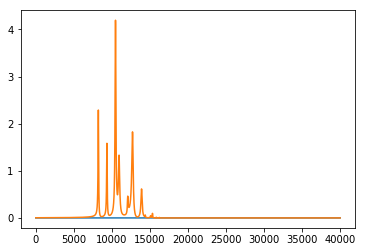

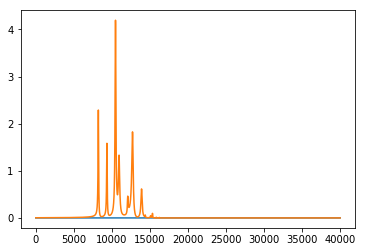

[[ 0.31516956-2.23611709e-19j -0.16602934-1.98666966e-03j
   0.01905577-4.11432359e-03j  0.05064868-1.89394703e-02j]
 [-0.16602934+1.98666966e-03j  0.33006297-3.71811367e-20j
  -0.24744024+3.38407209e-02j  0.0185187 -8.50585486e-03j]
 [ 0.01905577+4.11432359e-03j -0.24744024-3.38407209e-02j
   0.3307108 -1.76202658e-19j -0.15948888+3.17819679e-02j]
 [ 0.05064868+1.89394703e-02j  0.0185187 +8.50585486e-03j
  -0.15948888-3.17819679e-02j  0.32043453-8.54251952e-20j]]
(3, 4, 2, 3, 4, 2)
[0.31516956-1.50256396e-19j 0.31516956-2.23611709e-19j
 0.33006297-2.29119788e-19j 0.33006297-3.71811367e-20j
 0.3307108 -1.29216263e-20j 0.3307108 -1.76202658e-19j
 0.32043453+1.60846520e-20j 0.32043453-8.54251952e-20j
 0.34059298+2.88535816e-19j 0.34059298+7.60877147e-20j
 0.35370781+5.24506039e-19j 0.35370781-2.53478696e-19j
 0.3218894 +1.18641637e-19j 0.3218894 -3.82191959e-19j
 0.32432031-4.19591448e-19j 0.32432031-1.19823683e-20j
 0.31152808+9.46211040e-20j 0.31152808+1.41523856e-19j
 0.3518862 -8.812

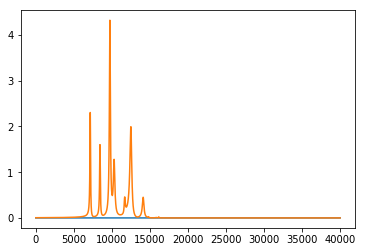

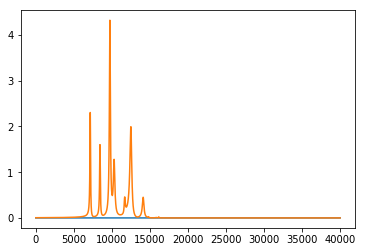

[[ 0.387888  +8.25038971e-20j -0.20600734-4.09034327e-03j
   0.01241094-2.72267401e-03j  0.08252705-3.02317142e-02j]
 [-0.20600734+4.09034327e-03j  0.39493411+7.18756661e-20j
  -0.29288032+3.85457752e-02j  0.01209772-5.61958966e-03j]
 [ 0.01241094+2.72267401e-03j -0.29288032-3.85457752e-02j
   0.39217686+1.30539602e-20j -0.19568014+3.67924172e-02j]
 [ 0.08252705+3.02317142e-02j  0.01209772+5.61958966e-03j
  -0.19568014-3.67924172e-02j  0.39252685-5.97487554e-22j]]
(3, 4, 2, 3, 4, 2)
[0.387888  +2.32595222e-21j 0.387888  +8.25038971e-20j
 0.39493411+1.27719626e-19j 0.39493411+7.18756661e-20j
 0.39217686+5.30434642e-19j 0.39217686+1.30539602e-20j
 0.39252685+1.15341523e-19j 0.39252685-5.97487554e-22j
 0.39764324+2.60195504e-19j 0.39764324-4.22714217e-19j
 0.40197362-1.15157641e-19j 0.40197362-3.28912378e-19j
 0.39284457+3.77303075e-19j 0.39284457-4.08012409e-20j
 0.39417725-5.12031866e-20j 0.39417725+8.02517109e-20j
 0.38690908-2.80737816e-22j 0.38690908-1.12615298e-19j
 0.40112478-2.166

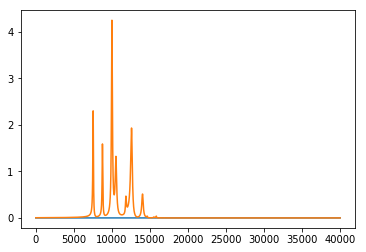

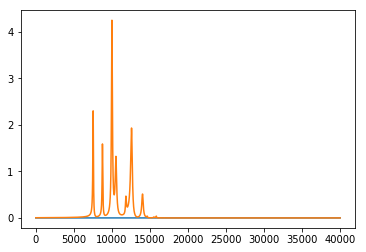

[[ 0.36036578+2.93900537e-20j -0.19081125-3.23797679e-03j
   0.01501639-3.27281442e-03j  0.07017597-2.58938181e-02j]
 [-0.19081125+3.23797679e-03j  0.37128379-1.22321339e-19j
  -0.27754894+3.70770481e-02j  0.01462434-6.76402939e-03j]
 [ 0.01501639+3.27281442e-03j -0.27754894-3.70770481e-02j
   0.37112461+5.28944440e-21j -0.18212254+3.49989368e-02j]
 [ 0.07017597+2.58938181e-02j  0.01462434+6.76402939e-03j
  -0.18212254-3.49989368e-02j  0.36447478-1.40440315e-19j]]
(3, 4, 2, 3, 4, 2)
[0.36036578+1.92152080e-19j 0.36036578+2.93900537e-20j
 0.37128379+2.81199317e-19j 0.37128379-1.22321339e-19j
 0.37112461-2.84791531e-20j 0.37112461+5.28944440e-21j
 0.36447478-1.47483934e-19j 0.36447478-1.40440315e-19j
 0.37847725+2.57226560e-19j 0.37847725-5.56868086e-19j
 0.38736645-5.74969720e-19j 0.38736645+3.06597984e-19j
 0.36553581+4.02052812e-19j 0.36553581-4.76487390e-19j
 0.36753457-2.78945661e-19j 0.36753457+3.26157976e-19j
 0.35775584+2.75987490e-19j 0.35775584+4.67656611e-20j
 0.38599513-4.591

KeyboardInterrupt: 

In [139]:
V_arr = np.linspace(-0.5,0.5,10)
e_arr = np.linspace(-10,20,40000)
mu0 = 0; beta = 2.5
Occ_store = Occ_V_sweep(mu0, V_arr, e_arr, n_it0 = 20, n_it = 40, beta = beta)

In [134]:
Occ_store2 = np.copy(Occ_store)

In [46]:
Occ_store[0,1,0,0,1,0]

array([ 3.82243247e-01+4.84643721e-19j, -5.18203144e-05-1.24196619e-04j])

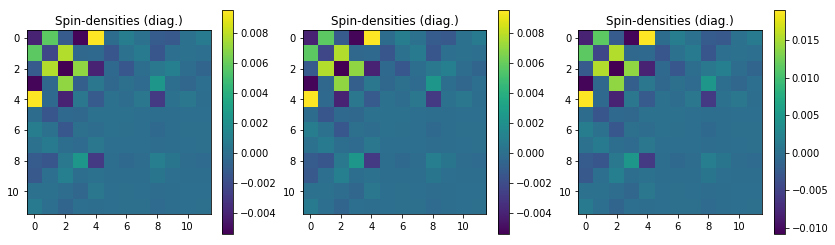

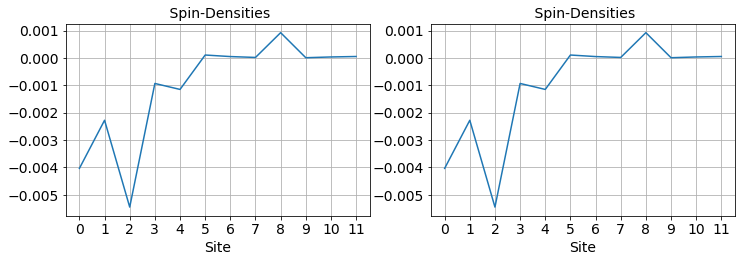

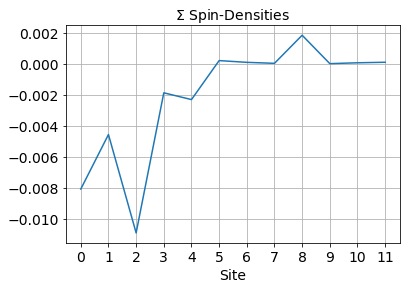

In [135]:
Occ_res_plot = np.reshape(Occ_store[-1], [H_shape[0]*H_shape[1]*2]*2)
Occ_res_plot2 = np.reshape(Occ_store2[-1], [H_shape[0]*H_shape[1]*2]*2)
plt.figure(figsize = (14,14))
plt.subplot(331);plt.imshow(((np.real(Occ_res_plot[1::2,1::2] - Occ_res_plot[::2,::2]))));plt.colorbar();plt.title('Spin-densities (diag.)');
plt.subplot(332);plt.imshow(((np.real(Occ_res_plot2[1::2,1::2] - Occ_res_plot2[::2,::2]))));plt.colorbar();plt.title('Spin-densities (diag.)');
plt.subplot(333);plt.imshow(((np.real(Occ_res_plot[1::2,1::2] - Occ_res_plot[::2,::2]) + np.real(Occ_res_plot2[1::2,1::2] - Occ_res_plot2[::2,::2]))));plt.colorbar();plt.title('Spin-densities (diag.)');plt.show()

plt.figure(figsize = (12,12))
plt.subplot(321);plt.plot((np.real(Occ_res_plot[1::2,1::2] - Occ_res_plot[::2,::2]))[np.arange(0,H_shape[0]*H_shape[1]),np.arange(0,H_shape[0]*H_shape[1])]);plt.grid(); plt.xlabel('Site', fontsize = 14); plt.title(' Spin-Densities', fontsize = 14); plt.xticks(np.arange(0,H_shape[0]*H_shape[1]),fontsize = 14);plt.yticks(fontsize = 14);
plt.subplot(322);plt.plot((np.real(Occ_res_plot2[1::2,1::2] - Occ_res_plot2[::2,::2]))[np.arange(0,H_shape[0]*H_shape[1]),np.arange(0,H_shape[0]*H_shape[1])]);plt.grid(); plt.xlabel('Site', fontsize = 14); plt.title(' Spin-Densities', fontsize = 14); plt.xticks(np.arange(0,H_shape[0]*H_shape[1]),fontsize = 14);plt.yticks(fontsize = 14);plt.show()

plt.plot((np.real(Occ_res_plot[1::2,1::2] - Occ_res_plot[::2,::2]) + np.real(Occ_res_plot2[1::2,1::2] - Occ_res_plot2[::2,::2]))[np.arange(0,H_shape[0]*H_shape[1]),np.arange(0,H_shape[0]*H_shape[1])]);plt.grid(); plt.xlabel('Site', fontsize = 14); plt.title(r'$\Sigma$' + ' Spin-Densities', fontsize = 14); plt.xticks(np.arange(0,H_shape[0]*H_shape[1]),fontsize = 14);plt.yticks(fontsize = 14);plt.show()


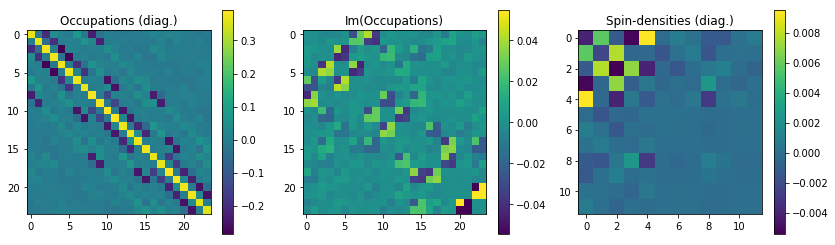

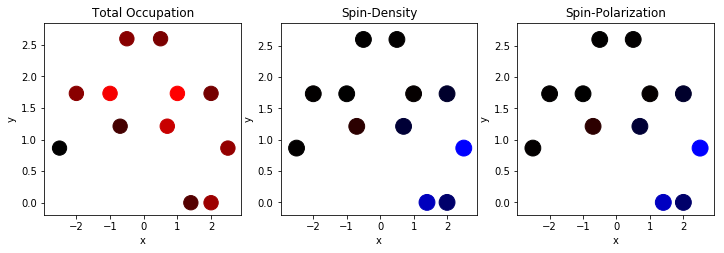

Min(Occ) = 0.3567850280067207
Max(Occ) = 0.39069162555686004
Max(SD_up) = 0.0009212810593180465
Max(SD_down) = -0.0054471696506360745
Max(SP_up) = 0.002517733465109807
Max(SP_down) = -0.01446706183882945
Dotsize is proportional to absolute value of occupations & SD/SPs, while color is proportional to relative occupations & SD/SPs.
For occupations, dots are black for min. occupation and red for max. occuptaions, while for SD/SP dots are black for zero SD/SP and red/blue for max. down/up-polarizations.
Dots of fully occupied/polarized sites are 2x the size of unoccupied/unpolarized sites


In [136]:
Occ_store.shape
Occ_res_plot = np.reshape(Occ_store[-1], [H_shape[0]*H_shape[1]*2]*2)

dsize_f = 2

plt.figure(figsize = (14,14))
plt.subplot(331);plt.imshow(np.real(Occ_res_plot));plt.colorbar();plt.title('Occupations (diag.)')
plt.subplot(332);plt.imshow(((np.imag(Occ_res_plot))));plt.colorbar();plt.title('Im(Occupations)')
plt.subplot(333);plt.imshow(((np.real(Occ_res_plot[1::2,1::2] - Occ_res_plot[::2,::2]))));plt.colorbar();plt.title('Spin-densities (diag.)');plt.show()

color_arr = np.zeros([H_shape[0],H_shape[1],3]); color_arr2 = np.zeros([H_shape[0],H_shape[1],3])

for i in range(0,H_shape[1]):
    color_arr[:,i,0] = 0.5*(np.real(Occ_store[-1,:,i,0,:,i,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]) + np.real(Occ_store[-1,:,i,1,:,i,1][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
color_arr2[:,:,0] = (color_arr[:,:,0] - np.min(color_arr[:,:,0]))/(np.max(color_arr[:,:,0]) - np.min(color_arr[:,:,0]))
occ_min_print = np.copy(np.min(color_arr[:,:,0]))
occ_max_print = np.copy(np.max(color_arr[:,:,0]))

plt.figure(figsize = (12,12))
plt.subplot(331)
dotsize_arr = color_arr[:,:,0]
for i in range(0,H_shape[1]):
    plt.scatter(Pos_arr[0,:,i], Pos_arr[1,:,i], s=list(150*(1 + (dsize_f - 1)*dotsize_arr[:,i])), color = list(color_arr2[:,i]))#np.real(Occ_store[-1,:,0,0,:,0,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
plt.title('Total Occupation');plt.xlabel('x');plt.ylabel('y')


color_arr_SP = np.zeros([H_shape[0],H_shape[1],3]); color_arr_SP2 = np.zeros([H_shape[0],H_shape[1],3])

for i in range(0,H_shape[1]):
    SP_val_i = np.real(Occ_store[-1,:,i,1,:,i,1][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]) - np.real(Occ_store[-1,:,i,0,:,i,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])])
    color_arr_SP[:,i,2] = (SP_val_i < 0)*np.abs(SP_val_i) #0.5*(np.real(Occ_store[-1,:,0,1,:,0,1][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]) - np.real(Occ_store[-1,:,0,0,:,0,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
    color_arr_SP[:,i,0] = (SP_val_i >= 0)*np.abs(SP_val_i)
color_max_SP = np.max(color_arr_SP)
#print(color_max_SP)
color_arr_SP2 = color_arr_SP/color_max_SP

Up_bool = (np.sum((color_arr_SP[:,:,0] == 0)*color_arr_SP[:,:,2]) > 0)
#print(((color_arr_SP[:,:,0] == 0)*color_arr_SP[:,:,2]))
#print(((color_arr_SP[:,:,0] == 0)))
Down_bool = (np.sum((color_arr_SP[:,:,2] == 0)*color_arr_SP[:,:,0]) > 0)
SD_max_down_print = -np.copy(np.max(color_arr_SP[:,:,2]))
SD_max_up_print = np.copy(np.max(color_arr_SP[:,:,0]))
if (Down_bool == True) and (np.max(color_arr_SP[:,:,2]) == 0):
    SD_max_down_print = 'No down-polarization'
if (Up_bool == True) and (np.max(color_arr_SP[:,:,0]) == 0):
    SD_max_up_print = 'No up-polarization'

plt.subplot(332)
dotsize_arr = np.max(color_arr_SP, axis = 2)
for i in range(0,H_shape[1]):
    plt.scatter(Pos_arr[0,:,i], Pos_arr[1,:,i], s=list(250*(1 + (dsize_f - 1)*dotsize_arr[:,i])), color = list(color_arr_SP2[:,i]))#np.real(Occ_store[-1,:,0,0,:,0,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
plt.title('Spin-Density');plt.xlabel('x');plt.ylabel('y')


color_arr_SP = np.zeros([H_shape[0],H_shape[1],3]); color_arr_SP2 = np.zeros([H_shape[0],H_shape[1],3])

for i in range(0,H_shape[1]):
    SP_val_i = 2*(np.real(Occ_store[-1,:,i,1,:,i,1][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]) - np.real(Occ_store[-1,:,i,0,:,i,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))/(np.real(Occ_store[-1,:,i,1,:,i,1][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]) + np.real(Occ_store[-1,:,i,0,:,i,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
    color_arr_SP[:,i,2] = (SP_val_i < 0)*np.abs(SP_val_i) #0.5*(np.real(Occ_store[-1,:,0,1,:,0,1][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]) - np.real(Occ_store[-1,:,0,0,:,0,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
    color_arr_SP[:,i,0] = (SP_val_i >= 0)*np.abs(SP_val_i)

Up_bool = (np.sum((color_arr_SP[:,:,0] == 0)*color_arr_SP[:,:,2]) > 0)
Down_bool = (np.sum((color_arr_SP[:,:,2] == 0)*color_arr_SP[:,:,0]) > 0)
SP_max_down_print = -np.copy(np.max(color_arr_SP[:,:,2]))
SP_max_up_print = np.copy(np.max(color_arr_SP[:,:,0]))
if (Down_bool == True) and (np.max(color_arr_SP[:,:,0]) == 0):
    SP_max_down_print = 'No down-polarization'
if (Up_bool == True) and (np.max(color_arr_SP[:,:,2]) == 0):
    SP_max_up_print = 'No up-polarization'

color_max_SP = np.max(color_arr_SP)
color_arr_SP2 = color_arr_SP/color_max_SP

plt.subplot(333)
dotsize_arr = np.max(color_arr_SP, axis = 2)
for i in range(0,H_shape[1]):
    plt.scatter(Pos_arr[0,:,i], Pos_arr[1,:,i], s=list(250*(1 + (dsize_f - 1)*dotsize_arr[:,i])), color = list(color_arr_SP2[:,i]))#np.real(Occ_store[-1,:,0,0,:,0,0][np.arange(0,H_shape[0]),np.arange(0,H_shape[0])]))
plt.title('Spin-Polarization');plt.xlabel('x');plt.ylabel('y')
plt.show()

print('Min(Occ) = ' + str(occ_min_print));print('Max(Occ) = ' + str(occ_max_print))
print('Max(SD_up) = ' + str(SD_max_up_print));print('Max(SD_down) = ' + str(SD_max_down_print))
print('Max(SP_up) = ' + str(SP_max_up_print));print('Max(SP_down) = ' + str(SP_max_down_print))
print('Dotsize is proportional to absolute value of occupations & SD/SPs, while color is proportional to relative occupations & SD/SPs.')
print('For occupations, dots are black for min. occupation and red for max. occuptaions, while for SD/SP dots are black for zero SD/SP and red/blue for max. down/up-polarizations.')
print('Dots of fully occupied/polarized sites are ' + str((dsize_f)) + 'x the size of unoccupied/unpolarized sites')

#### Obtaining the current and transmissions

(3, 4, 2, 3, 4, 2)


C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


0.004252078667217465


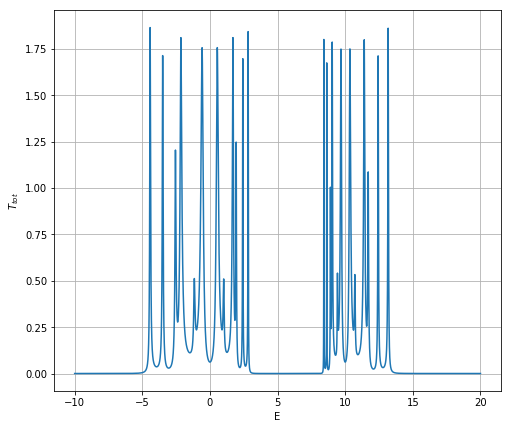

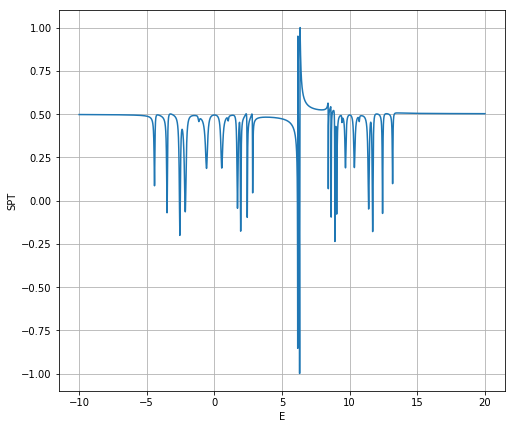

In [119]:

#e_arr = np.linspace(-5,5,5000)
I_store = np.zeros([len(V_arr)], dtype = 'complex128')

for j in range(0,len(V_arr)):
    muL_j = mu0 + V_arr[j]/2; muR_j = mu0 - V_arr[j]/2
    FD_diff_arr = FD_dist(e_arr, muL_j, beta) - FD_dist(e_arr, muR_j, beta)
    
    
    T_store = np.zeros([len(e_arr)])
    T_pol_store = np.zeros([4,len(e_arr)])

   # Occ_res_j = np.reshape(Occ_store[j], [2*H_shape[0]*H_shape[1], 2*H_shape[0]*H_shape[1]])
    #n_arr_vec_j = Occ_res_j[np.arange(0,2*H_shape[0]*H_shape[1]), np.arange(0,2*H_shape[0]*H_shape[1])]
    n_arr_j = get_n_arr_res(Occ_store[j])
    
    for i in range(0,len(e_arr)):
        G_ret_res = generate_GF_ret_res(e_arr[i], n_arr_j)
        
       # G_ret_res = np.linalg.inv((e_arr[i] + 0.0000000j)*np.eye(Hres.shape[0], Hres.shape[1]) - Hres - Sigma_tot_res)
        G_adv_res = np.conj(np.transpose(G_ret_res))
        T_tot = np.trace(np.dot(Gamma_L_res, np.dot(G_ret_res, np.dot(Gamma_R_res, G_adv_res))))
        T_store[i] = T_tot

        Ti_down = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_down,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_down,G_adv_res))))))
        Ti_up = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_up,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_up,G_adv_res))))))
        Ti_du = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_up,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_down,G_adv_res))))))
        Ti_ud = np.trace(np.dot(Gamma_L_res,np.dot(Spin_res_down,np.dot(G_ret_res,np.dot(Gamma_R_res,np.dot(Spin_res_up,G_adv_res))))))

        T_pol_store[:,i] = np.array([Ti_down, Ti_up, Ti_du, Ti_ud])

        #print(Ti_down + Ti_up + Ti_du + Ti_ud - T_tot)
        #print((-Ti_down + Ti_up + Ti_du - Ti_ud)/ T_tot)
    #I_store_j = np.abs(e_arr[1] - e_arr[0])*np.sum(T_store*FD_diff_arr)
    I_store_j = integrate_n_flipaxes(T_store*FD_diff_arr, 3, np.abs(e_arr[1] - e_arr[0]))
    I_store[j] = I_store_j
    print(I_store_j)
    
SPT_store = (T_pol_store[1] + T_pol_store[2] - T_pol_store[0] - T_pol_store[3])/T_store

plt.figure(figsize = (8,7))
plt.plot(e_arr, T_store)
plt.xlabel('E');plt.ylabel(r'$T_{tot}$');plt.grid();plt.show()

plt.figure(figsize = (8,7))
plt.plot(e_arr, SPT_store)
plt.xlabel('E');plt.ylabel('SPT');plt.grid();plt.show()


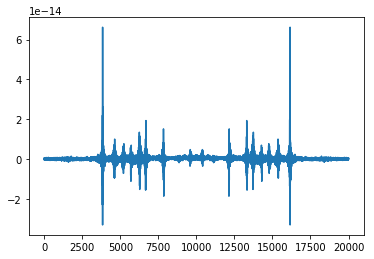

In [513]:
plt.plot(SPT_store +np.flip(SPT_store))

In [116]:
SPT_store2 = np.copy(SPT_store)
T_store2 = np.copy(T_store)

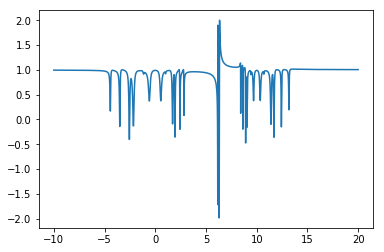

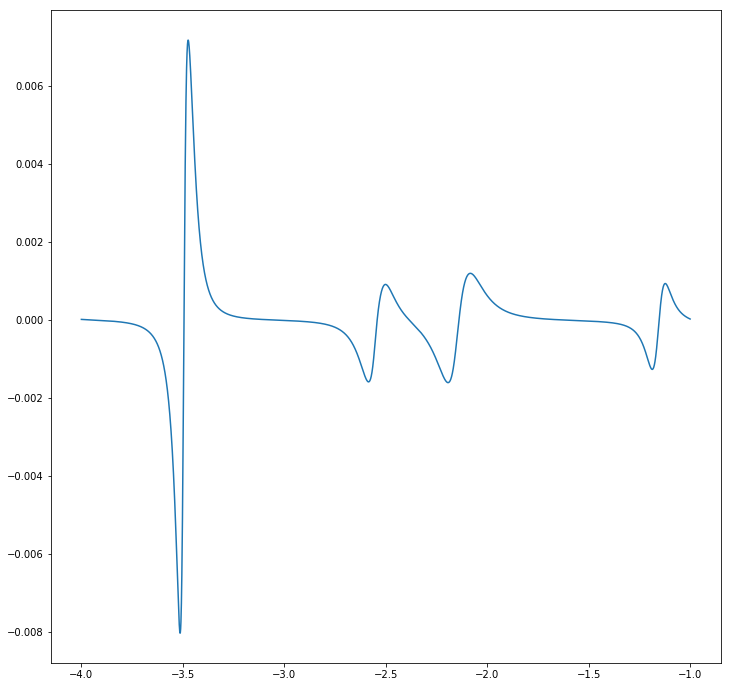

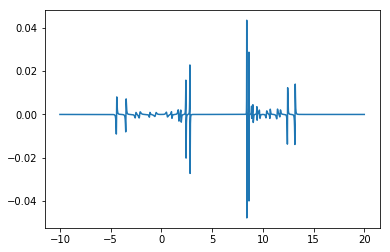

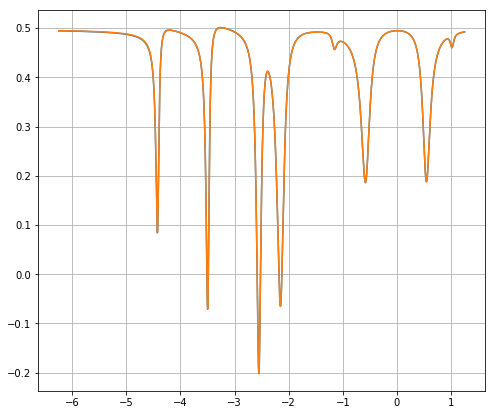

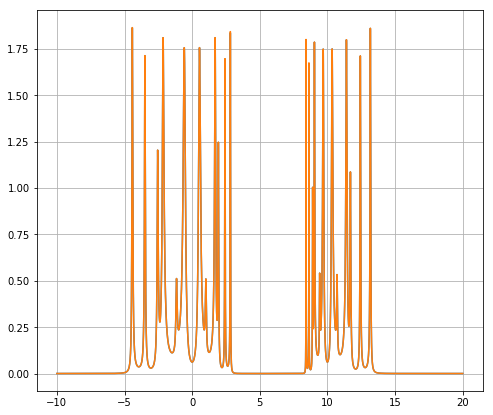

In [120]:
plt.plot(e_arr,SPT_store2 + SPT_store);plt.show()
plt.figure(figsize  = (12,12))
plt.plot(e_arr[8000:12000],(T_store2 - T_store)[8000:12000]);plt.show()
plt.plot(e_arr[:],(T_store2 - T_store)[:]);plt.show();
plt.figure(figsize = (8,7))
plt.plot(e_arr[5000:15000],SPT_store2[5000:15000]);plt.plot(e_arr[5000:15000],SPT_store[5000:15000]);plt.grid();plt.show()
plt.figure(figsize = (8,7))
plt.plot(e_arr,T_store2);plt.plot(e_arr,T_store);plt.grid();plt.show()

#### Comparing the currents
Here, the difference between two currents can be determined. This can be used to obtain the current-difference $\Delta I$ and Magnetoresistance $\Delta I/\Sigma I$, which are plotted below. 

In [53]:
I_store2 = np.copy(I_store)

C:\Programs\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


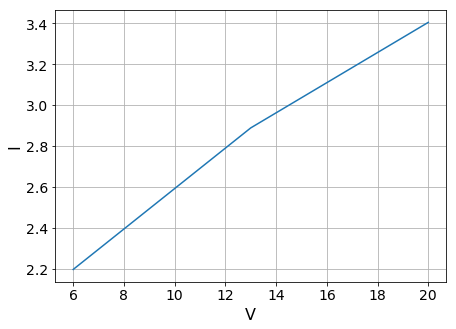

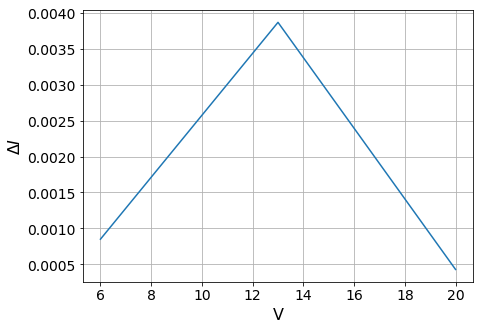

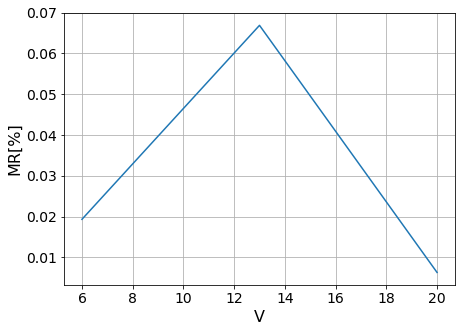

In [59]:
plt.figure(figsize = (7,5))
plt.plot(V_arr, I_store);
plt.xlabel('V', fontsize = 16);plt.ylabel('I', fontsize = 16)
plt.xticks(fontsize = 14);plt.yticks(fontsize = 14)
plt.grid();plt.show()

plt.figure(figsize = (7,5))
plt.plot(V_arr, I_store2 - I_store);
plt.xlabel('V', fontsize = 16);plt.ylabel(r'$\Delta I$', fontsize = 16)
plt.xticks(fontsize = 14);plt.yticks(fontsize = 14)
plt.grid();plt.show()

plt.figure(figsize = (7,5))
plt.plot(V_arr, 100*(I_store2 - I_store)/(I_store2 + I_store));
plt.xlabel('V', fontsize = 16);plt.ylabel('MR[%]', fontsize = 16)
plt.xticks(fontsize = 14);plt.yticks(fontsize = 14)
plt.grid();plt.show()